The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/topi-0.6.dev0-py3-none-any.whl
!pip install mxnet-cu100
!pip install git+https://github.com/d2l-ai/d2l-tvm


# Convolution

:label:`ch_conv_cpu`


In this section, we will optimize the convolution operator defined in :numref:`ch_conv` on CPUs. Specifically, this is a 2-D convolution operator.

## Setup

In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm

target = 'llvm -mcpu=skylake-avx512'

Let's first define our performance baseline, which is the convolution operator provided by MXNet. To simplify the measurement, we use the same number of input and output channels, and the same size of height and width of input and kernel tensors. The padding will be `(kernel - 1) // 2` and the stride will be 1 so that the output will have the same width and height as the input, i.e. `SAME` padding.

In [2]:
# Save to the d2ltvm package.
def conv_gflop(oc, ic, n, k, p, s):
    """Compute the #floating point operations in a convolution.

    The arguments are output channels oc, input channels ic, input size n,
    kernel size k, padding p and stride s.
    """
    on = d2ltvm.conv_out_size(n, k, p, s)
    return 2 * oc * ic * on * on * k * k / 1e9

# Save to the d2ltvm package.
def conv_timer_mxnet(c, n, k, ctx):
    """Benchmark convolution in MXNet

    c : input, output channels
    n : input width and height
    k : kernel width and height
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'c, n, k, p, s = %d, %d, %d, %d, 1\n'
        'data, weight, bias, out = d2ltvm.get_conv_data_mxnet(\n'
        '    c, c, n, k, p, s, "%s")'%(c, n, k, (k-1)//2, ctx),
        stmt='d2ltvm.conv_mxnet(data, weight, bias, out, k, p, s);'
        'out.wait_to_read()')
    return timer.timeit

# Save to the d2ltvm package.
def bench_conv_mxnet(sizes, ctx='cpu'):
    """Return the GFLOPS of MXNet convolution"""
    return [conv_gflop(c, c, n, k, (k-1)//2, 1) /
            d2ltvm.bench_workload(conv_timer_mxnet(c, n, k, ctx))
            for c, n, k in sizes]

Then benchmark its performance with various numbers of channels, when the input and kernel width/height are fixed to be 64 and 3, respectively.

In [3]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]
mxnet_gflops = bench_conv_mxnet(sizes)

Similar to the `bench_matmul_tvm` method implemented in :numref:`ch_matmul_cpu`, we implement the reusable method to benchmark the convolution operator. Note that the first argument `func` here is a function that takes input argments `oc, ic, n, k, p, s` and returns the schedule as well as its corresonding tensor symbolic argments.

In [4]:
# Save to the d2ltvm package.
def bench_conv_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx=ctx, number=nrepeats)
        return timer(x, k, y).mean * nrepeats
    gflops, times = [], []
    for (c, n, k) in sizes:
        args = c, c, n, k, (k-1)//2, 1 # oc, ic, n, k, p, s
        s, (X, K, Y) = func(*args)
        mod = tvm.build(s, [X, K, Y], target)
        ctx = tvm.context(target, 0)
        x, k, y = d2ltvm.get_conv_data(
            *args, lambda x: tvm.nd.array(x, ctx=ctx))
        times.append(d2ltvm.bench_workload(workload))
        gflops.append(conv_gflop(*args))
    return np.array(gflops) / np.array(times)

## Blocked Convolution

Just as we tiled matrices into blocks to improve the cache efficiency for matrix multiplication in :numref:`ch_block_matmul_cpu`, we can do the same thing for convolution. Let's consider the case with a single output channel for simplicity.

Consider a block of $Y$, denoted as `Y[i:i+tw, j:j+th]`, where `th` and `tw` are the tile sizes for height and width, respectively. We know the it can be computed by applying the convolution on a block of $X$ with kernel $K$. In particular, assuming the width and height of $K$ are `kw` and `kh`, then

`Y[i:i+tw, j:j+th] = conv(X[i:i+tw+kw-1, Y[j:j+th+kh-1], K)`

The elements that needed for a block are illustrated in :numref:`fig_conv_block`. If we choose proper `tw` and `th`, we can fit data into the cache to improve its efficiency. This is easy to be generated to multiple output channels as it simply adds the number of kernels accordingly.

![Compute a block of $Y$ in convolution.](http://tvm.d2l.ai/_images/conv_block.svg)

:label:`fig_conv_block`


The implementation of this schedule is similar to the one for matrix multiplication defined in :numref:`ch_block_matmul_cpu`. But also note the following two differences:

1. We parallelize the outer data blocks across the output channels.
2. We move the inner height and width axes before the reduction axes, since they are more effectively to be optimized through vectorization and unrolling.

In [5]:
th, tw = 8, 8  # Tile sizes for height and weight

def cached_block(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    s = tvm.create_schedule(Y.op)
    CachedY = s.cache_write(Y, 'local')
    # Compute the output block for every output channel in parallel
    oc, h, w = Y.op.axis
    ho, wo, hi, wi = s[Y].tile(h, w, th, tw)
    ochw = s[Y].fuse(oc, ho, wo)
    s[Y].parallel(ochw)
    # Cache the output block, and move the inner height and width axes
    # to innermost, so we can vectorize and unroll them
    s[CachedY].compute_at(s[Y], ochw)
    _,  ch, cw = CachedY.op.axis
    ric, rkh, rkw = CachedY.op.reduce_axis
    s[CachedY].reorder(ric, rkh, rkw, ch, cw)
    s[CachedY].vectorize(cw)
    s[CachedY].unroll(ch)
    # Schedule the padding by adding thread-level parallelism
    if PaddedX != X:
        s[PaddedX].parallel(PaddedX.op.axis[0])
    return s, (X, K, Y)

s, args = cached_block(32, 32, 64, 3, 1, 1)
tvm.lower(s, args, simple_mode=True)

// attr [PaddedX] storage_scope = "global"
allocate PaddedX[float32 * 139392]
produce PaddedX {
  parallel (i0, 0, 32) {
    for (i1, 0, 66) {
      for (i2, 0, 66) {
        PaddedX[(((i0*4356) + (i1*66)) + i2)] = tvm_if_then_else(((((i1 < 1) || (65 <= i1)) || (i2 < 1)) || (65 <= i2)), 0f, X[((((i0*4096) + (i1*64)) + i2) - 65)])
      }
    }
  }
}
produce Y {
  parallel (c.i.outer.fused.j.outer.fused, 0, 2048) {
    // attr [Y.local] storage_scope = "local"
    allocate Y.local[float32 * 64]
    produce Y.local {
      Y.local[ramp(0, 1, 8)] = x8(0f)
      Y.local[ramp(8, 1, 8)] = x8(0f)
      Y.local[ramp(16, 1, 8)] = x8(0f)
      Y.local[ramp(24, 1, 8)] = x8(0f)
      Y.local[ramp(32, 1, 8)] = x8(0f)
      Y.local[ramp(40, 1, 8)] = x8(0f)
      Y.local[ramp(48, 1, 8)] = x8(0f)
      Y.local[ramp(56, 1, 8)] = x8(0f)
      for (ric, 0, 32) {
        for (rkh, 0, 3) {
          for (rkw, 0, 3) {
            Y.local[ramp(0, 1, 8)] = (Y.local[ramp(0, 1, 8)] + (PaddedX[ramp((((((ric*4356

The output pseudo code becomes a bit long, but as long as you understand the scheduling primitives we used above, the code should make sense if you take a close look.

Now let's benchmark its performance and compare with our baseline.

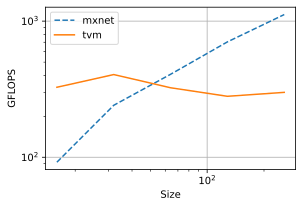

In [6]:
tvm_gflops = bench_conv_tvm(cached_block, sizes, target)
d2ltvm.plot_gflops(channels, [mxnet_gflops, tvm_gflops], ['mxnet', 'tvm'])

As we can seen that our schedule does well for small channel sizes, while its performance decrease for large channel sizes. We will optimize the later in :numref:`ch_packed_conv_cpu`.

## Summary

- We tile the input and output data of convolution as we did for matrix multiplication for better cache efficiency.

## Exercises

- Try different tiling sizes.